Lab 10: Image Classification
---

### Image Classification Problem

In this lab we will introduce the Image Classification problem, which is the task of assigning an input image one label from a fixed set of categories. This is one of the core problems in Computer Vision that, despite its simplicity, has a large variety of practical applications. Moreover, as we will see later in the course, many other seemingly distinct Computer Vision tasks (such as object detection, segmentation) can be reduced to image classification.

**Example.** For example, in the image below an image classification model takes a single image and assigns probabilities to 4 labels, {cat, dog, hat, mug}. As shown in the image, keep in mind that to a computer an image is represented as one large 3-dimensional array of numbers. In this example, the cat image is 248 pixels wide, 400 pixels tall, and has three color channels Red,Green,Blue (or RGB for short). Therefore, the image consists of 248 x 400 x 3 numbers, or a total of 297,600 numbers. Each number is an integer that ranges from 0 (black) to 255 (white). Our task is to turn this quarter of a million numbers into a single label, such as “cat”.

![Image Classification](img/classify.png)

The task in Image Classification is to predict a single label (or a distribution over labels as shown here to indicate our confidence) for a given image. Images are 3-dimensional arrays of integers from 0 to 255, of size Width x Height x 3. The 3 represents the three color channels Red, Green, Blue.

**Challenges.** Since this task of recognizing a visual concept (e.g. cat) is relatively trivial for a human to perform, it is worth considering the challenges involved from the perspective of a Computer Vision algorithm. As we present (an inexhaustive) list of challenges below, keep in mind the raw representation of images as a 3-D array of brightness values:

- Viewpoint variation. A single instance of an object can be oriented in many ways with respect to the camera.
- Scale variation. Visual classes often exhibit variation in their size (size in the real world, not only in terms of their extent in the image).
- Deformation. Many objects of interest are not rigid bodies and can be deformed in extreme ways.
- Occlusion. The objects of interest can be occluded. Sometimes only a small portion of an object (as little as few pixels) could be visible.
- Illumination conditions. The effects of illumination are drastic on the pixel level.
- Background clutter. The objects of interest may blend into their environment, making them hard to identify.
- Intra-class variation. The classes of interest can often be relatively broad, such as chair. There are many different types of these objects, each with their own appearance.

A good image classification model must be invariant to the cross product of all these variations, while simultaneously retaining sensitivity to the inter-class variations.

![Image Classification Challenges](img/challenges.jpeg)


**Data-driven approach.** How might we go about writing an algorithm that can classify images into distinct categories? Unlike writing an algorithm for, for example, sorting a list of numbers, it is not obvious how one might write an algorithm for identifying cats in images. Therefore, instead of trying to specify what every one of the categories of interest look like directly in code, the approach that we will take is not unlike one you would take with a child: we’re going to provide the computer with many examples of each class and then develop learning algorithms that look at these examples and learn about the visual appearance of each class. This approach is referred to as a data-driven approach, since it relies on first accumulating a training dataset of labeled images. Here is an example of what such a dataset might look like:

![Image Classification Training Set](img/trainset.jpg)

An example training set for four visual categories. In practice we may have thousands of categories and hundreds of thousands of images for each category.

**The image classification pipeline.** We’ve seen that the task in Image Classification is to take an array of pixels that represents a single image and assign a label to it. Our complete pipeline can be formalized as follows:

- **Input:** Our input consists of a set of N images, each labeled with one of K different classes. We refer to this data as the training set.
- **Learning:** Our task is to use the training set to learn what every one of the classes looks like. We refer to this step as training a classifier, or learning a model.
- **Evaluation:** In the end, we evaluate the quality of the classifier by asking it to predict labels for a new set of images that it has never seen before. We will then compare the true labels of these images to the ones predicted by the classifier. Intuitively, we’re hoping that a lot of the predictions match up with the true answers (which we call the ground truth).

### Image Classificiation Datasets

Example image classification dataset: **[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).** 

One popular toy image classification dataset is the CIFAR-10 dataset. This dataset consists of 60,000 tiny images that are 32 pixels high and wide. Each image is labeled with one of 10 classes (for example “airplane, automobile, bird, etc”). These 60,000 images are partitioned into a training set of 50,000 images and a test set of 10,000 images. In the image below you can see 10 random example images from each one of the 10 classes:

![Image Classification Training Set](img/cifar10.jpg)

Left: Example images from the CIFAR-10 dataset. Right: first column shows a few test images and next to each we show the top 10 nearest neighbors in the training set according to pixel-wise difference.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time

In [2]:
from keras.datasets import cifar10  
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def cifar_plot(data, label, im_idx=0):
    im = data[im_idx, :]

    print("shape: ", im.shape)
    print("label: ", label[im_idx])
    plt.imshow(im) 
    plt.show()

shape:  (32, 32, 3)
label:  [0]


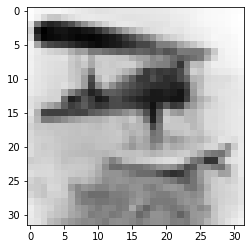

In [4]:
cifar_plot(X_train,y_train,2021)

***[MNIST](http://yann.lecun.com/exdb/mnist/)*** dataset

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

In [5]:
import keras
from keras.datasets import mnist  
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = mnist.load_data()

In [6]:
def mnist_plot(data, label, im_idx=0):
    im = data[im_idx, :]

    print("shape: ", im.shape)
    print("label: ", label[im_idx])
    plt.imshow(im, cmap=plt.get_cmap('gray')) 
    plt.show()

shape:  (28, 28)
label:  9


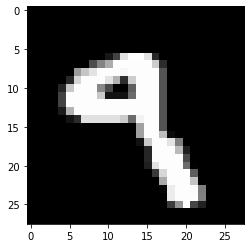

In [7]:
mnist_plot(X_mnist_train,y_mnist_train,424)

### K - Nearest Neighbor Classifier

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

The optimal choice of the value $k$ is highly data-dependent: in general a larger $k$ suppresses the effects of noise, but makes the classification boundaries less distinct.

For $k=1$, it's the nearest neighbor classifer.

In this section of the lab, you are going to implement the nearest neighbor clasifer.

Suppose now that we are given the CIFAR-10 training set of 50,000 images (5,000 images for every one of the labels), and we wish to label the remaining 10,000. The nearest neighbor classifier will take a test image, compare it to every single one of the training images, and predict the label of the closest training image. 

In the image describing the CIFAR-10 above and on the right you can see an example result of such a procedure for 10 example test images. 

Notice that in only about 3 out of 10 examples an image of the same class is retrieved, while in the other 7 examples this is not the case. For example, in the 8th row the nearest training image to the horse head is a red car, presumably due to the strong black background. As a result, this image of a horse would in this case be mislabeled as a car.

You may have noticed that we left unspecified the details of exactly how we compare two images, which in this case are just two blocks of 32 x 32 x 3. One of the simplest possibilities is to compare the images pixel by pixel and add up all the differences. In other words, given two images and representing them as vectors $I_1$,$I_2$, a reasonable choice for comparing them might be the $L_1$ distance:

$$\|I_1-I_2\|_1=\sum_{p}|I_1^p-I_2^p|$$

For the images, this can be examplified by:

![Image Classification L1 distance](img/l1_distance.jpeg)

An example of using pixel-wise differences to compare two images with L1 distance (for one color channel in this example). Two images are subtracted elementwise and then all differences are added up to a single number. If two images are identical the result will be zero. But if the images are very different the result will be large.


In [8]:
import numpy as np

class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      
      # Exercise: Calculate distances using l1 norm
      # Hint: np.sum and np.abs can be useful (Which axis do we want to sum over?)
      distances = 0 
      min_index = np.argmin(distances) # get the index with smallest distance
      
      # Exercise: Find the predicted class
      # Hint: use self to reference attributes of the class
      Ypred[i] = 1

    return Ypred

In [9]:
X_train_flatten = X_train.reshape(X_train.shape[0], 32 * 32 * 3) # becomes 50000 x 3072
X_test_flatten = X_test.reshape(X_test.shape[0], 32 * 32 * 3)   # becomes 10000 x 3072

# create a Nearest Neighbor classifier class
nn = NearestNeighbor() 

# train the classifier on the training images and labels
nn.train(X_train_flatten[:200], y_train[:200]) 

# predict labels on the test images
y_test_predict = nn.predict(X_test_flatten)

In [10]:
print(y_test_predict)
print(y_test.flatten())

[8 1 9 ... 3 4 2]
[3 8 8 ... 5 1 7]


In [11]:
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print ('accuracy: %f' % ( np.mean(y_test_predict == y_test.ravel()) ))

accuracy: 0.176300


You may also consider nereat neighbor classifier with $L_2$ distance.

$$\|I_1-I_2\|_2=\sqrt{\sum_{p}(I_1^p-I_2^p)^2}$$

In [12]:
import numpy as np

class NearestNeighbor_L2_distance(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L2 distance 
     
     # Exercise: Calculate distances using l2 norm
      # Hint: np.sum, np.sqrt, and np.square can be useful (Which axis do we want to sum over?)
      distances = 0 
      min_index = np.argmin(distances) # get the index with smallest distance
      
      # Find the predicted class
      # Use the same code from previous class
      Ypred[i] = 1

    return Ypred

Now, let's consider K - Nearest Neighbor Classifier. 

In [13]:
knn = KNeighborsClassifier(n_neighbors=1, p=2)
print ('accuracy: %f' %(knn.fit(X_train_flatten, y_train.ravel()).score(X_test_flatten, y_test.ravel())))

accuracy: 0.353900


In [14]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
print ('accuracy: %f' %(knn.fit(X_train_flatten, y_train.ravel()).score(X_test_flatten, y_test.ravel())))

accuracy: 0.339800


In [15]:
knn = KNeighborsClassifier(n_neighbors=10, p=2)
print ('accuracy: %f' %(knn.fit(X_train_flatten, y_train.ravel()).score(X_test_flatten, y_test.ravel())))

accuracy: 0.338600


### Digits Classification with MNIST

In [16]:
X_mnist_train_flatten = X_mnist_train.reshape(X_mnist_train.shape[0], 28*28) 
X_mnist_test_flatten = X_mnist_test.reshape(X_mnist_test.shape[0], 28*28)   

In [17]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)

tic = time.time()
knn_fit = knn.fit(X_mnist_train_flatten, y_mnist_train)
knn_train_time = time.time()-tic

tic = time.time()
knn_accuracy = knn_fit.score(X_mnist_test_flatten, y_mnist_test)
knn_predict_time = time.time()-tic

print('KNN score: %f' % knn_accuracy)
print('KNN train time cost: %f seconds' % knn_train_time)
print('KNN predict time cost: %f seconds' % knn_predict_time)


logistic = LogisticRegression(max_iter=1000)

tic = time.time()
logistic_fit = logistic.fit(X_mnist_train_flatten, y_mnist_train)
logistic_train_time = time.time()-tic

tic = time.time()
logistic_accuracy = logistic_fit.score(X_mnist_test_flatten, y_mnist_test)
logistic_predict_time = time.time()-tic

print('LogisticRegression score: %f' % logistic_accuracy)
print('LogisticRegression train time cost: %f seconds' % logistic_train_time)
print('LogisticRegression predict time cost: %f seconds' % logistic_predict_time)


KNN score: 0.968800
KNN train time cost: 0.004294 seconds
KNN predict time cost: 17.038181 seconds
LogisticRegression score: 0.920100
LogisticRegression train time cost: 85.451970 seconds
LogisticRegression predict time cost: 0.041524 seconds


/opt/anaconda3/envs/MIE424/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Automatically created module for IPython interactive environment
Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
Training set score: 0.986800
Test set score: 0.970000


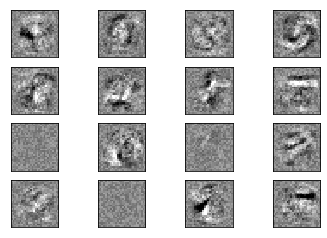

In [18]:
import warnings

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

print(__doc__)

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

# References

https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html

https://cs231n.github.io/classification/